In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from collections import Counter
import time
import operator
#nltk.download('stopwords')
#from nltk.corpus import stopwords

In [2]:
#Importing dataset with codes description
descr = pd.read_csv('desc.csv', encoding = "ISO-8859-1", sep = ';', dtype = str)
#descr.head()

In [3]:
descr = descr[['code', 'name', 'notes']]

In [4]:
descr_test = []
for i in range(len(descr)):
    if len(descr.iloc[i,0]) == 2:
        descr_test.append(descr.iloc[i])
pd.DataFrame(descr_test).head()

,code,name,notes
0,01,"Jordbruk og tjenester tilknyttet jordbruk, jak...",Denne næringen to basisaktiviteter: produksj...
72,02,Skogbruk og tjenester tilknyttet skogbruk,produksjon av rundtømmer og utnyttelse og in...
85,03,"Fiske, fangst og akvakultur","fiske og akvakultur, som dekker bruk av fisk..."
101,05,Bryting av steinkull og brunkull,minedrift under og over jorden og aktivitete...
108,06,Utvinning av råolje og naturgass,"produksjon av råolje, utvinning av olje av o..."


In [5]:
desc_y = pd.DataFrame(descr_test).iloc[:,0].values
desc_X = pd.DataFrame(descr_test).iloc[:,1].values
desc_X2 = pd.DataFrame(descr_test).iloc[:,2].values
del descr_test

In [6]:
for i in range(len(desc_X2)):
    if not pd.isnull(desc_X2[i]):
        pos = desc_X2[i].find('Ekskluderer: ')
        if pos != -1: 
            desc_X2[i] = desc_X2[i][1:(pos-1)].lower().replace('omfatter ', '')
        else:
            desc_X2[i] = desc_X2[i][1:].lower().replace('omfatter ', '')

desc_X2[0]

'denne næringen  to basisaktiviteter: produksjon av vegetabilske og animalske produkter, jordbruk, dyrking av genetisk modifiserte vekster og oppdrett av genetisk modifiserte dyr. både dyrking av vekster på friland og i veksthus inngår i  også tjenester tilknyttet jordbruk, jakt og fangst'

In [7]:
#Importing dataset with company's descriptions
dataset = pd.read_csv('BESK_ALLE.csv', encoding = "ISO-8859-1", sep=';', dtype = 'str')

In [8]:
dataset = dataset[:1575675]

In [9]:
dataset = dataset[~dataset.besk.isnull()]

In [10]:
#define y and X
X = dataset.iloc[:, 1].values
y = dataset.iloc[:, 0].values

In [11]:
stopWords = pd.read_csv('StopWords.csv', encoding = "ISO-8859-1").values.tolist()

In [12]:
#Add descriptions to X_desc dataset
X_desc = X
X_desc = np.concatenate((X_desc, desc_X), axis = None)
X_desc = np.concatenate((X_desc, desc_X2), axis = None)
del desc_X
del desc_X2

In [13]:
#Add codes of descriptions to y_2
y_2 = []
for i in range(len(y)):
    y_2.append(y[i][:2])
y_2.extend(desc_y)
y_2.extend(desc_y)
y_2 = np.array(y_2)
del desc_y

In [14]:
#Remove empty descriptions
y_2 = y_2[~pd.DataFrame(X_desc)[0].isnull()]
X_desc = X_desc[~pd.DataFrame(X_desc)[0].isnull()]

In [15]:
X_cleaned = []
for i in range(len(X_desc)):
    #removing numbers, punctuations, accent marks and other diacritics
    description = re.sub(pattern = '[^a-øA-Ø]', repl = ' ', string = X_desc[i])
    #converting all letters to lower case
    description = description.lower()
    description = description.split()
    description = [word for word in description if not [word] in stopWords]
    description = ' ' .join(description)
    X_cleaned.append(description)

In [16]:
del stopWords
del X_desc
del descr

In [17]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features = 1500)
X_bag = cv.fit_transform(X_cleaned).toarray()
del X_cleaned
del cv

In [18]:
#Get labels where only 1 example is given
labels_list = []
tmp = list(Counter(y).items())
for i in tmp:
    if i[1] < 2:
        labels_list.append(i[0])
del tmp
labels_list

['24.320', '51.220', '64.110', '01.120', '01.640', '64.910']

In [19]:
#Get indexes where only 1 example is given(index_1) and more than 1 is given(index_wo01)
index_1 = np.where(pd.DataFrame(y)[0].isin(labels_list))
index_wo1 = np.where(~pd.DataFrame(y)[0].isin(labels_list))
del labels_list

In [20]:
# Splitting the dataset into the Training set and Test set
# StratifiedShuffleSplit is used for inbalanced datasets
from sklearn.cross_validation import StratifiedShuffleSplit
sss =  StratifiedShuffleSplit(y[index_wo1], 1, test_size = 0.20, random_state = 0)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
#get indexes of splitting
index_train = list(sss)[0][0]
index_test = list(sss)[0][1]
del sss

In [22]:
#X sets for fasttext
X_train = X[index_1]
X_train = np.concatenate((X_train, X[index_wo1][index_train]), axis = None)
X_test = X[index_wo1][index_test]

In [23]:
#y sets for fasttext
y_train = y[index_1]
y_train = np.concatenate((y_train, y[index_wo1][index_train]), axis = None)
y_test = y[index_wo1][index_test]

In [24]:
#sets for RandomForest 
#after split to train_set is added desc_X, desc_X2
index_tmp = np.concatenate((index_1, list(range(len(X), len(X_bag)))), axis = None)
del index_1

In [25]:
#X sets for RandomForest
X_bag_train = X_bag[index_tmp]
X_bag_test = X_bag[index_wo1][index_test]
X_bag_train = np.concatenate((X_bag_train, X_bag[index_wo1][index_train]), axis = 0)
del X_bag

In [26]:
#y sets for RandomForest
y_2_train = y_2[index_tmp]
y_2_train = np.concatenate((y_2_train, y_2[index_wo1][index_train]), axis = None)
y_2_test = y_2[index_wo1][index_test]

In [27]:
del index_tmp
del index_train
del index_test
del index_wo1

In [28]:
# Fitting Weighted RandomForest to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0, class_weight = 'balanced')
classifier.fit(X_bag_train, y_2_train)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [ ]:
# Fitting Weighted Naive Bayes to the Training set
#from sklearn.naive_bayes import ComplementNB
#classifier = ComplementNB()
#classifier.fit(X_bag_train, y_2_train)

In [ ]:
filename = 'RF_model_2_10_lbl_desc.sav'
#save the model to disk
import pickle
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
#load the model from disk
classifier = pickle.load(open(filename, 'rb'))

In [30]:
# Predicting the Test set results
y_2_pred = classifier.predict(X_bag_test)

In [31]:
y_2_pred_prob = classifier.predict_proba(X_bag_test)

In [34]:
#see model work
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
def metrics_score(test, pred):
    print('accuracy: ', accuracy_score(test, pred))
    print('precision: ', precision_score(test, pred, average='macro'))
    print('recall: ', recall_score(test, pred, average='macro'))
    print('f1: ', f1_score(test, pred, average='macro'))

In [35]:
metrics_score(y_2_test, y_2_pred)

accuracy:  0.5094864707916975
precision:  0.32390436780122
recall:  0.33321631158138615
f1:  0.30938609398363776


In [36]:
labels = np.unique(y_2_test)

In [37]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_2_test, y_2_pred, labels)

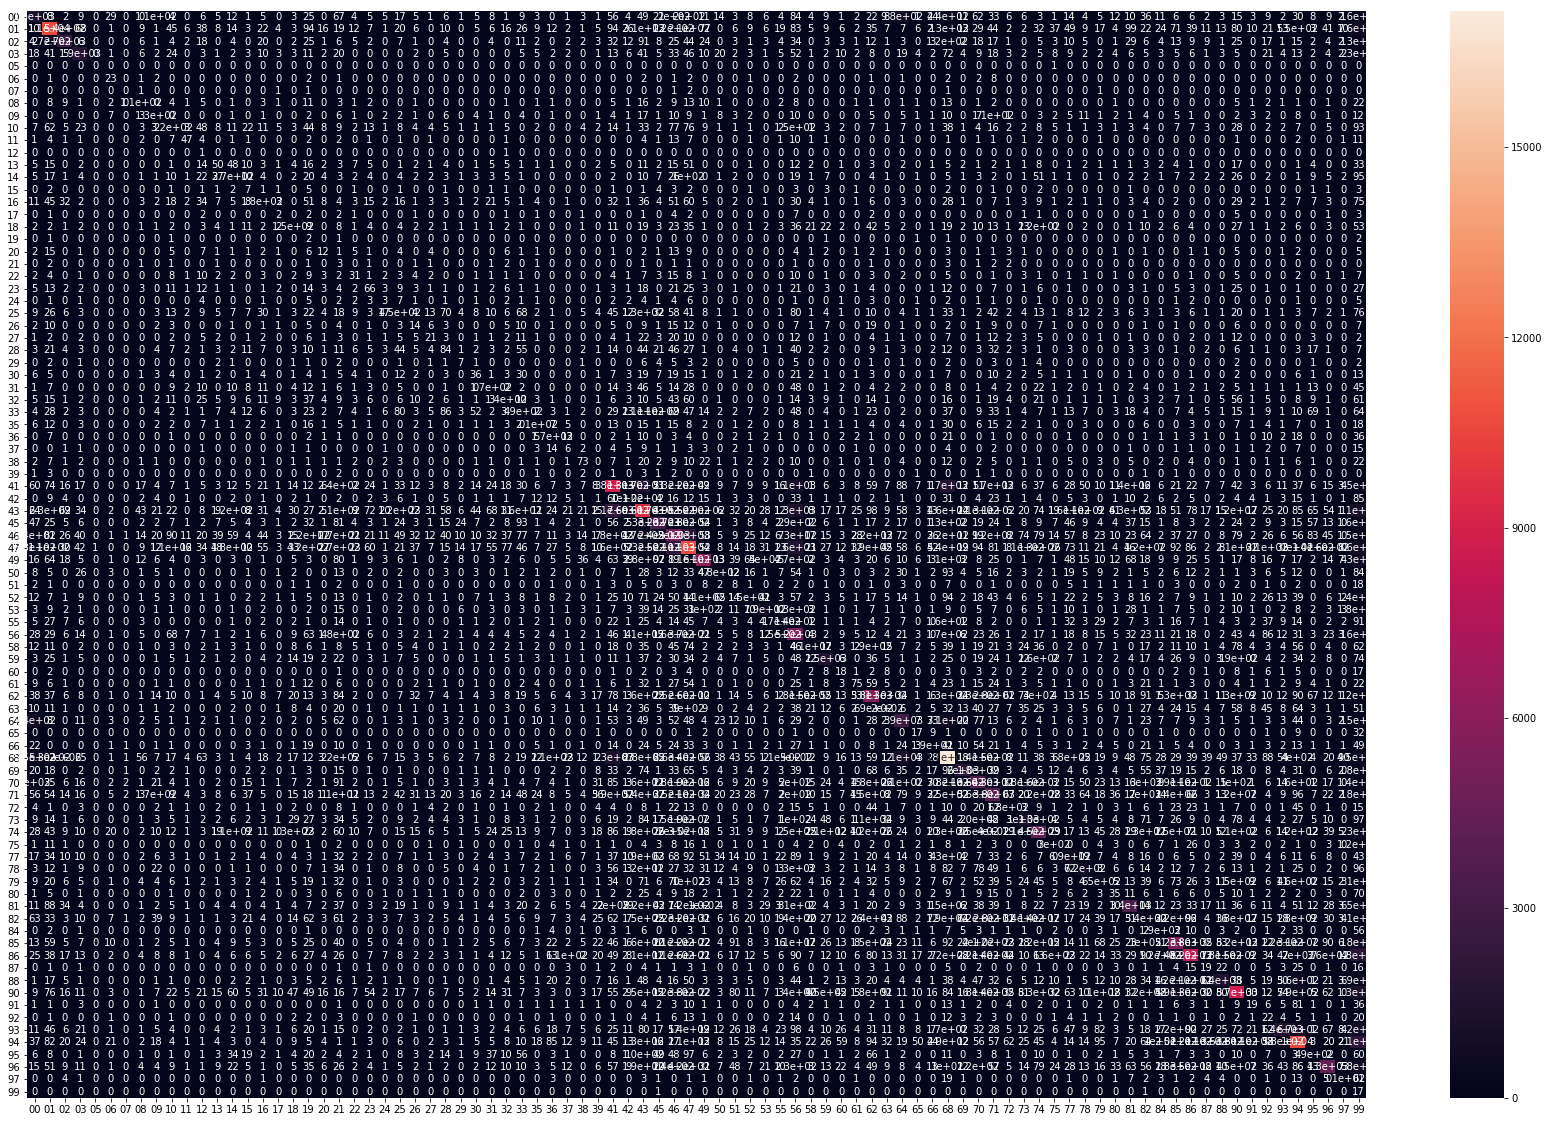

In [38]:
fig = plt.figure(figsize = (30,20))
import seaborn as sn
sn.heatmap(pd.DataFrame(cm, index = labels, columns = labels), annot = True)

In [41]:
pd.DataFrame([X_train[i] + ' __label__' + y_train[i] for i in range(len(X_train))]).to_csv('ft_input_train.csv', encoding = "utf-8", index = None, header = None)
#pd.DataFrame([X_test[i] + ' __label__' + y_test[i] for i in range(len(X_test))]).to_csv('ft_input_test.csv', encoding = "utf-8", index = None, header = None)

In [42]:
import fastText
from fastText import train_supervised, tokenize, load_model, unicode_literals
import io

In [43]:
#Loading for pretrained vector
#ISO-8859-1
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    fin.close()
    return data

In [44]:
ts_before = time.time()
#from Paul code
model = train_supervised(
    input = 'ft_input_train.csv',
    wordNgrams = 3,
    #label = '__label__',
    verbose = 2,
    minCount = 1, # minimal number of word occurences
    neg = 10, #number of negatives sampled
    dim = 300,
    pretrainedVectors = 'cc.nn.300.vec'
)
ts_after = time.time()
print(ts_after - ts_before)

554.7037973403931


In [45]:
y_pred = []
for i in range(len(X_test)):
    pred = model.predict(X_test[i])[0][0]
    pos = pred.find('.')
    y_pred.append(pred[pos-2 :pos+4])

In [46]:
metrics_score(y_test, y_pred)

accuracy:  0.5231949684736286


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.2511332306207621
recall:  0.13408636154786793
f1:  0.15256403367824325


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
#2 level with RandomForest
y_lvl_pred = []
for t in range(len(X_test)):
    pred = model.predict(X_test[t], k = 50)
    res = {}
    res.clear()
    for i in range(len(pred[0])):
        for j in range(len(y_2_pred_prob[0])):
            pos = pred[0][i].find('.')
            if pred[0][i][pos-2:pos] == classifier.classes_[j]:
                if pred[0][i][pos-2:pos+4] not in res:
                    res[pred[0][i][pos-2:pos + 4]] = y_2_pred_prob[t][j] * pred[1][i]
    y_lvl_pred.append(max(res.items(), key = operator.itemgetter(1))[0])

In [48]:
metrics_score(y_test, y_lvl_pred)

accuracy:  0.5116093839743854


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.21907824872056766
recall:  0.13539691232232756
f1:  0.1491829191363632


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
#Get 5 first predictions with 2 level dataset
def pred_2_lvl(classifier, model, text):
    pred = model.predict(text, k = 50)
    res = {}
    for i in range(len(pred[0])):
        for j in range(len(y_2_pred_prob[0])):
            pos = pred[0][i].find('.')
            if pred[0][i][pos-2:pos] == classifier.classes_[j]:
                if pred[0][i][pos-2:pos+4] not in res:
                    res[pred[0][i][pos-2:pos + 4]] = y_2_pred_prob[4][j] * pred[1][i]
    return(sorted(res.items(), key = operator.itemgetter(1), reverse = True)[0:5])

In [51]:
pred_2_lvl(classifier, model, X_test[4])

[('68.100', 0.1679665446281433),
 ('68.209', 0.14223669469356537),
 ('68.310', 0.013621766120195389),
 ('68.320', 0.007211485877633095),
 ('64.308', 0.0)]